In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data_generator import SyntheticESCDataGenerator
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [57]:
def generate_synthetic_data(num_chambers: int, records_per_chamber: int) -> pd.DataFrame:
    df = pd.DataFrame()
    start_time = '2025-07-01 05:00:00'
    chamber = "chamber_1"
    for i in range(num_chambers):
        gen = SyntheticESCDataGenerator(chamber=chamber)
        psu_df = gen.generate(records_per_chamber, start_time=start_time)
        df = pd.concat([df, psu_df], ignore_index=True)
        start_time = psu_df['timestamp'].max() + pd.Timedelta(minutes=1)
        chamber = f"chamber_{i+1}"
    return df

df_train = generate_synthetic_data(num_chambers=30, records_per_chamber=1000)

In [58]:
# -------------------------
# Dataset preparation
# -------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]


def create_sequences(data, seq_length, return_indices=False):
    sequences = []
    indices = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        sequences.append(seq)
        indices.append(i)
    seq_tensor = torch.tensor(np.array(sequences), dtype=torch.float32)
    if return_indices:
        return seq_tensor, indices
    return seq_tensor

In [59]:
# -------------------------
# LSTM Autoencoder
# -------------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_size=64, latent_dim=16, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(
            input_size=n_features, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        self.latent = nn.Linear(hidden_size, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, hidden_size)
        self.decoder = nn.LSTM(
            input_size=hidden_size, hidden_size=n_features,
            num_layers=num_layers, batch_first=True
        )

    def forward(self, x):
        # Encoder
        enc_out, _ = self.encoder(x)
        enc_last = enc_out[:, -1, :]          # last hidden state
        z = self.latent(enc_last)

        # Decoder
        dec_in = self.decoder_input(z).unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder(dec_in)
        return dec_out

In [60]:
# -------------------------
# Example Training Script
# -------------------------
def train_autoencoder(df, seq_length=10, epochs=20, batch_size=32, lr=1e-3, use_gpu=True):
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Normalize
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(numeric_df.values)

    # Make sequences
    sequences = create_sequences(data_scaled, seq_length)
    dataset = TimeSeriesDataset(sequences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Pick device
    device = torch.device("cuda" if (torch.cuda.is_available() and use_gpu) else "cpu")
    print(f"Using device: {device}")

    # Model
    n_features = numeric_df.shape[1]
    model = LSTMAutoencoder(n_features=n_features).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)  # move batch to GPU
            optimizer.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    return model, scaler, device

In [61]:
# -------------------------
# Anomaly Scoring (with metadata)
# -------------------------
def compute_reconstruction_error(model, scaler, df, seq_length=10, device="cpu"):
    """
    Compute reconstruction error for each sequence and return a dataframe
    that includes timestamp, chamber, and reconstruction error.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    data_scaled = scaler.transform(numeric_df.values)

    sequences, indices = create_sequences(data_scaled, seq_length, return_indices=True)
    sequences = sequences.to(device)

    with torch.no_grad():
        recon = model(sequences)
        errors = torch.mean((recon - sequences) ** 2, dim=(1, 2)).cpu().numpy()

    # Attach metadata: chamber + timestamp from the sequence start
    meta_df = df.iloc[indices].copy()
    meta_df["reconstruction_error"] = errors
    return meta_df

In [62]:
def analyze_reconstruction_errors(errors, percentile=95):
    """
    Plot reconstruction error distribution and compute anomaly threshold.
    
    Args:
        errors (array-like): reconstruction errors from compute_reconstruction_error()
        percentile (int): percentile to use for anomaly threshold (default=95)
        
    Returns:
        threshold (float): computed threshold
    """
    errors = np.array(errors)

    # Compute threshold
    threshold = np.percentile(errors, percentile)

    # Plot distribution
    plt.figure(figsize=(8,5))
    plt.hist(errors, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
    plt.axvline(threshold, color="red", linestyle="--", label=f"{percentile}th percentile = {threshold:.2f}")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")
    plt.title("Distribution of Reconstruction Errors")
    plt.legend()
    plt.show()

    return threshold


def label_anomalies(errors, threshold):
    """
    Label each sequence as normal (0) or anomaly (1).
    """
    return (errors > threshold).astype(int)


In [63]:
# 1. Train model on training data
model, scaler, device = train_autoencoder(df_train, seq_length=20, epochs=15)

Using device: cuda
Epoch 1/15, Loss: 0.080555
Epoch 2/15, Loss: 0.075392
Epoch 3/15, Loss: 0.074318
Epoch 4/15, Loss: 0.073997
Epoch 5/15, Loss: 0.073974
Epoch 6/15, Loss: 0.073966
Epoch 7/15, Loss: 0.073959
Epoch 8/15, Loss: 0.073954
Epoch 9/15, Loss: 0.073883
Epoch 10/15, Loss: 0.073739
Epoch 11/15, Loss: 0.073690
Epoch 12/15, Loss: 0.073540
Epoch 13/15, Loss: 0.073396
Epoch 14/15, Loss: 0.073345
Epoch 15/15, Loss: 0.073175


In [64]:
# 2. Compute reconstruction errors on training set
train_results = compute_reconstruction_error(model, scaler, df_train, seq_length=20, device=device)
train_errors = train_results["reconstruction_error"].values

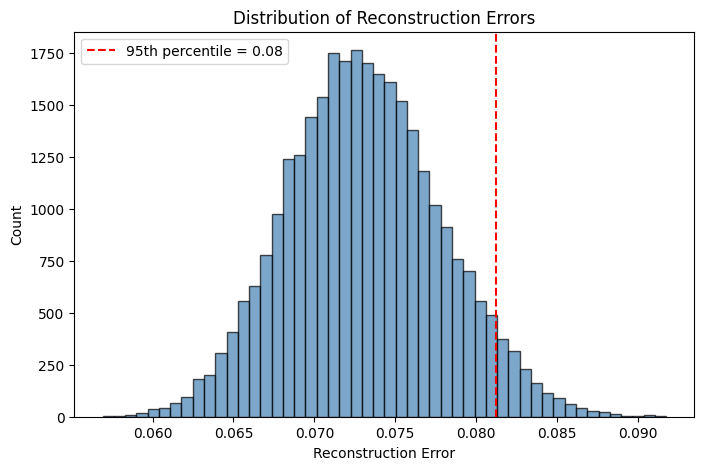

Anomaly threshold: 0.081242345


In [65]:
# 3. Analyze training errors & get threshold
threshold = analyze_reconstruction_errors(train_errors, percentile=95)
print("Anomaly threshold:", threshold)

In [66]:
# 4. Test on new data
df_test = generate_synthetic_data(num_chambers=10, records_per_chamber=1000)
test_results = compute_reconstruction_error(model, scaler, df_test, seq_length=20, device=device)

In [67]:
# 5. Label anomalies
test_results["anomaly"] = (test_results["reconstruction_error"] > threshold).astype(int)

# Show anomalies by chamber
print(test_results[test_results["anomaly"] == 1][["timestamp", "chamber", "reconstruction_error"]].head())

              timestamp    chamber  reconstruction_error
119 2025-07-01 05:01:59  chamber_1              0.081259
124 2025-07-01 05:02:04  chamber_1              0.081742
125 2025-07-01 05:02:05  chamber_1              0.083229
126 2025-07-01 05:02:06  chamber_1              0.083228
127 2025-07-01 05:02:07  chamber_1              0.082118


In [ ]:
test_results